In [1]:
import pandas as pd
from pandas import Series, DataFrame
import os  # dealing with directories
import cv2  # working with, mainly resizing, images
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from PIL import Image as im
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,f1_score
import warnings
warnings.filterwarnings("ignore")

<B> Note: This code is not my code, i did not write it.  
    I understand every line in the code but i don't own it.

In [2]:
def dfbuilder(files):
    final=pd.DataFrame(columns=['Time_x', 'Experiment_x', ' Hand Type_x', ' # hands_x', ' Position X_x',
       ' Position Y_x', ' Position Z_x', ' Velocity X_x', ' Velocity Y_x',
       ' Velocity Z_x', ' Pitch_x', ' Roll_x', ' Yaw_x', ' Wrist Pos X_x',
       ' Wrist Pos Y_x', ' Wrist Pos Z_x', ' Elbow pos X_x', ' Elbow Pos Y_x',
       ' Elbow Pos Z_x', ' Grab Strenth_x', ' Grab Angle_x',' Pinch Strength_x', 
       'Time_y', 'Experiment_y',
       ' Hand Type_y', ' # hands_y', ' Position X_y', ' Position Y_y',
       ' Position Z_y', ' Velocity X_y', ' Velocity Y_y', ' Velocity Z_y',
       ' Pitch_y', ' Roll_y', ' Yaw_y', ' Wrist Pos X_y', ' Wrist Pos Y_y',
       ' Wrist Pos Z_y', ' Elbow pos X_y', ' Elbow Pos Y_y', ' Elbow Pos Z_y',
       ' Grab Strenth_y', ' Grab Angle_y', ' Pinch Strength_y'])
    for file in files:
        temp=pd.read_csv(file)
        # ignoring the first 7 seconds has been said.
        temp=temp.iloc[700:]
        temp[" Hand Type"]=Series([1 if i=="right" else 2 for i in temp[" Hand Type"]])
        # if the file contain the alone (left hand) string the function tries to merge it with the right hand that suits.
        if str.__contains__(file,"Alone"):  
            temp.insert(loc=1, column='Experiment', value="1")
            temp=temp.drop(' Frame ID',axis=1) # drop fram id column.
        # reading the hand right data.
            Handright=pd.read_csv('/Users/idobar/Documents/GitHub/test/extraFiles/HandRight.csv')
        # insert values by the hand type.
            Handright[" Hand Type"]=Series([1 if i=="right" else 2 for i in Handright[" Hand Type"]])
            Handright.insert(loc=1, column='Experiment', value="1")
            Handright = Handright.iloc[:len(temp)-1]
            Handright = Handright.reset_index(drop=True)
            Handright=Handright.drop(' Frame ID',axis=1) # drop frame id column from hand right data frame.
            temp = temp.reset_index(drop=True)
            temp = pd.merge(temp, Handright, left_index=True, right_index=True)# merging alone and right.
        # if the string is not containing the aline string it checks if the string contain Sync or Spontan.  
        # if the string contain one of the two it gives the Experiment the matching value.
        else:
            if str.__contains__(file,"Sync"):
                temp.insert(loc=1, column='Experiment', value="2")
            if str.__contains__(file,"Spontan"):
                temp.insert(loc=1, column='Experiment', value="3") 
            dfright=temp[temp[" Hand Type"]==1]
            dfleft=temp[temp[" Hand Type"]==2]
            dfright.set_index(' Frame ID',inplace=True)
            dfleft.set_index(' Frame ID',inplace=True)
            # after create the index for both dfleft and dfright, the function will merge it by the frame id.
            temp=pd.merge(dfleft, dfright, how='left',on=' Frame ID') 
        final=pd.concat([final,temp])
        
    final=final.drop(["Experiment_y"],axis=1) 
    final=final.dropna() # dropping null values from the data.
    final[final.index%20==2] 
    final.sort_index(inplace=True) # sorting the data by increasing order of the frame id.
    return final

In [3]:
import glob
#The glob module finds all the pathnames matching a specified pattern.
test= dfbuilder(glob.glob('/Users/idobar/Documents/GitHub/test/extraFiles/Validation/**/*.csv', recursive=True))
train= dfbuilder(glob.glob('/Users/idobar/Documents/GitHub/test/extraFiles/Training/**/*.csv', recursive=True))
train.head()

,Time_x,Experiment_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,624.5214,1,2.0,1,-129.871500,238.8927,15.15365,-260.49200,268.55510,57.91444,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,507.6639,1,2.0,1,-54.173900,404.6508,102.53100,-46.37540,-141.27270,-30.21356,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,591.7358,1,1.0,1,-19.865460,181.0220,102.09490,-36.13705,-89.59768,-43.82156,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,712.9770,1,2.0,1,-81.244640,198.4695,59.23386,-171.53010,226.72650,431.11130,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,300.3558,1,2.0,1,0.483595,263.7752,48.87287,-73.14426,247.44700,-70.95473,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0


In [4]:
train.tail()

,Time_x,Experiment_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
147031,496.3350,2,2.0,2,-88.72741,133.6054,80.84770,19.672070,109.4840,-148.49250,...,-0.450688,148.5828,145.7623,81.60815,361.1390,39.55280,166.3942,0.0,0.181054,0.0
147033,496.3516,2,2.0,2,-88.94987,136.6372,79.13829,5.798031,201.9729,-96.20036,...,-0.448909,148.3703,145.3627,81.36929,361.1625,39.38863,165.8574,0.0,0.178520,0.0
147035,496.3684,2,2.0,2,-89.34464,140.2418,77.55276,-62.854220,271.6032,-69.40147,...,-0.447422,148.3899,145.1390,81.37563,362.0198,39.16170,163.7183,0.0,0.176777,0.0
147037,496.3849,2,2.0,2,-90.04370,144.5540,76.09414,-25.792180,229.5740,-96.95150,...,-0.447172,148.6771,145.2287,81.51376,363.2723,39.67188,161.8624,0.0,0.174231,0.0
147039,496.4013,2,2.0,2,-91.27801,150.2716,75.28820,-82.378340,386.3372,-18.65937,...,-0.448133,149.3459,145.9781,81.90491,364.6587,39.78413,159.4454,0.0,0.173893,0.0


In [5]:
train.groupby('Experiment_x').count()

,Time_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
Experiment_x,,,,,,,,,,,,,,,,,,,,,
1,26222,26222,26222,26222,26222,26222,26222,26222,26222,26222,...,26222,26222,26222,26222,26222,26222,26222,26222,26222,26222
2,30991,30991,30991,30991,30991,30991,30991,30991,30991,30991,...,30991,30991,30991,30991,30991,30991,30991,30991,30991,30991
3,31156,31156,31156,31156,31156,31156,31156,31156,31156,31156,...,31156,31156,31156,31156,31156,31156,31156,31156,31156,31156


In [6]:
train['Experiment_x'].value_counts()

3    31156
2    30991
1    26222
Name: Experiment_x, dtype: int64

In [7]:
train.shape

(88369, 43)

## Visualization

In [8]:
train.isnull().sum().sum()

0

In [9]:
test.isnull().sum().sum()

0

In [10]:
print("Train shape:",train.shape)
print("Test shape:",test.shape)

Train shape: (88369, 43)
Test shape: (25233, 43)


<AxesSubplot:xlabel='Experiment_x', ylabel='count'>

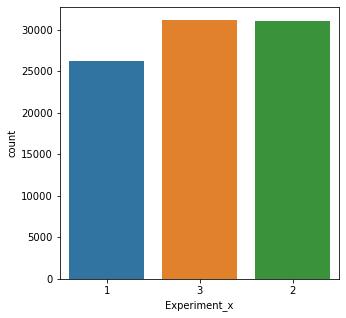

In [11]:
plt.figure(figsize = (5,5))
sns.countplot(x = "Experiment_x", data = train)

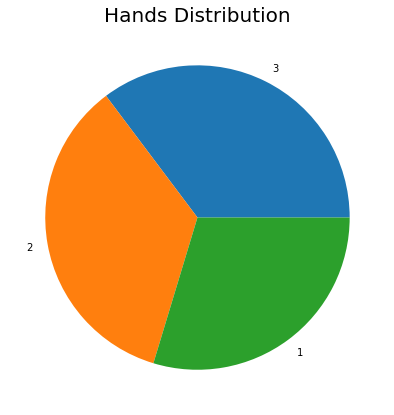

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(7, 7))
axes= train.Experiment_x.value_counts().plot(kind='pie')
axes.set_title("Hands Distribution", fontsize=20)
axes.set_xlabel("")
axes.set_ylabel("")

fig1 = plt.gcf()
plt.show()
plt.draw()

Text(0, 0.5, 'Y pos left')

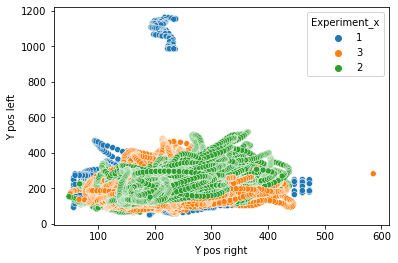

In [13]:
sns.scatterplot(x=" Position Y_y", y=" Position Y_x", hue="Experiment_x", data=train)
plt.xlabel('Y pos right')
plt.ylabel('Y pos left')

In [14]:
data_Alone = train[train['Experiment_x']=='1']
data_NotAlone = train[train['Experiment_x']!='1']

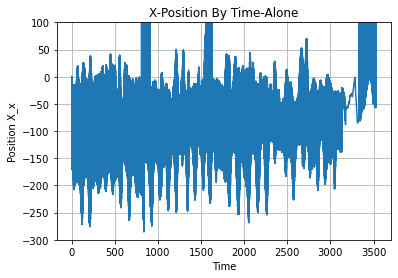

In [15]:
fig, ax = plt.subplots()
ax.plot(data_Alone[' Position X_x'])
ax.set(xlabel = 'Time', ylabel = 'Position X_x', title = 'X-Position By Time-Alone')
ax.grid()
plt.ylim(-300,100)
plt.show()

In [16]:
data_Spontan = train[train['Experiment_x']=='2']
data_NotSpontan = train[train['Experiment_x']!='2']

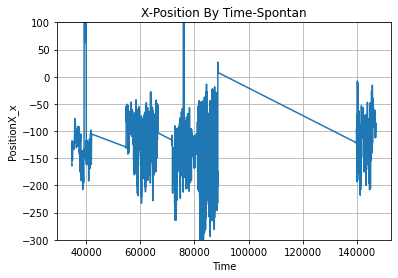

In [17]:
fig, ax = plt.subplots()
ax.plot(data_Spontan[' Position X_x'])
ax.set(xlabel = 'Time', ylabel = 'PositionX_x', title = 'X-Position By Time-Spontan')
ax.grid()
plt.ylim(-300,100)
plt.show()

In [18]:
data_Sync = train[train['Experiment_x']=='3']
data_NotSync = train[train['Experiment_x']!='3']

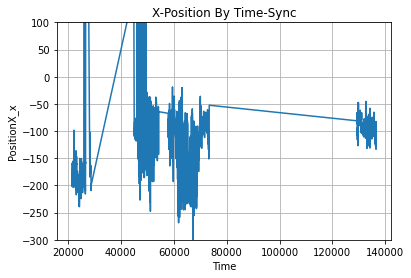

In [19]:
fig, ax = plt.subplots()
ax.plot(data_Sync[' Position X_x'])
ax.set(xlabel = 'Time', ylabel = 'PositionX_x', title = 'X-Position By Time-Sync')
ax.grid()
plt.ylim(-300,100)
plt.show()

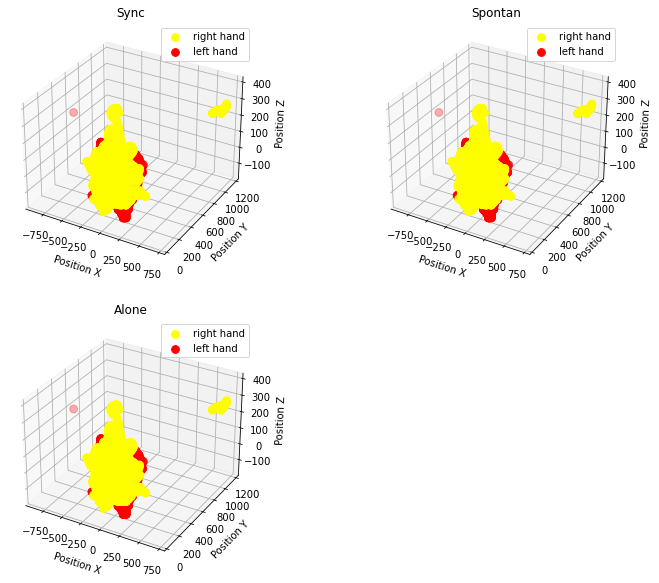

In [20]:
df = train.drop('Experiment_x',axis=1)
fig = plt.figure(figsize=(12, 10))
Type = ['Sync', 'Spontan','Alone']
count = 1
for t in Type:
    ax = fig.add_subplot(2, 2, count, projection='3d')
    count+=1
    ax.title.set_text(t)
    plt.gca().legend(('left','right'))
    ax.scatter(df[' Position X_x'], df[' Position Y_x'], df[' Position Z_x' ], color='yellow',s=60, label='right hand')
    ax.scatter(df[' Position X_y'], df[' Position Y_y'], df[' Position Z_y'],s=60, color='red', label='left hand')
    plt.legend()
    ax.set_xlabel('Position X')
    ax.set_ylabel('Position Y')
    ax.set_zlabel('Position Z')

## Preprocessing 

In [21]:
train.drop(['Time_x',' Hand Type_x',' # hands_x','Time_y', ' Hand Type_y', ' # hands_y'],axis = 1, inplace = True)
test.drop(['Time_x',' Hand Type_x',' # hands_x','Time_y', ' Hand Type_y', ' # hands_y'],axis = 1, inplace = True)

In [22]:
# Droping the Experiment_x column in order to get the target of the data.
y=train['Experiment_x']
x=train.drop(['Experiment_x'], axis = 1)
y_test_test=test['Experiment_x']
X_test_test=test.drop(['Experiment_x'], axis = 1)

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(x,y, train_size=0.8, random_state=0)

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test_test = scaler.transform(X_test_test)

In [25]:
print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)

(70695, 36)
(70695,)
(17674, 36)
(17674,)


(None, None)

In [26]:
print("The train set as:",len(X_train),"Samples")
print("The test set as:",len(X_val),"Samples")

The train set as: 70695 Samples
The test set as: 17674 Samples


## Models

### KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 30))
acc = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    neigh_pred = knn.predict(X_val)
    acc.append(metrics.accuracy_score(y_val, neigh_pred))
acc

[0.9993776168382935,
 0.9993210365508657,
 0.9992644562634379,
 0.9988683942514428,
 0.9989815548262985,
 0.9984157519520199,
 0.9980762702274527,
 0.997567047640602,
 0.9973973067783184,
 0.9967183433291841,
 0.9966051827543284,
 0.9959262193051941,
 0.9953038361434876,
 0.9945117121194975,
 0.9935498472332239,
 0.993097204933801,
 0.9924748217720946,
 0.9917392780355324,
 0.9911168948738259,
 0.9900418694126966,
 0.9894194862509902,
 0.9883444607898608,
 0.9876654973407265,
 0.9870996944664479,
 0.9864773113047415,
 0.9856286069933236,
 0.9850062238316171,
 0.9841575195201991,
 0.9841009392327713]

### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)
clf_pred=clf.predict(X_val)

Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      5128
           2       0.83      0.81      0.82      6249
           3       0.81      0.84      0.82      6297

    accuracy                           0.87     17674
   macro avg       0.88      0.88      0.88     17674
weighted avg       0.87      0.87      0.87     17674

Accuracy: 0.8708837840896232


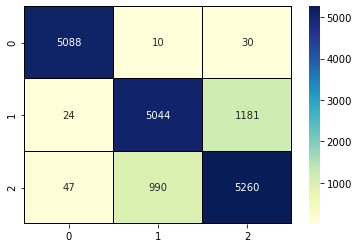

In [29]:
confMatrix = confusion_matrix(y_val, clf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, clf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,clf_pred)
print("Accuracy:",result2)

### Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_val)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5128
           2       1.00      1.00      1.00      6249
           3       1.00      1.00      1.00      6297

    accuracy                           1.00     17674
   macro avg       1.00      1.00      1.00     17674
weighted avg       1.00      1.00      1.00     17674

Accuracy: 0.9993776168382935


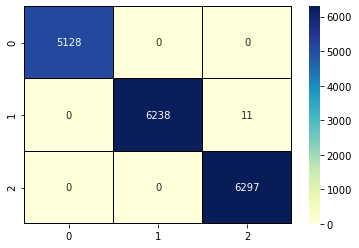

In [31]:
confMatrix = confusion_matrix(y_val, rf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, rf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,rf_pred)
print("Accuracy:",result2)

### Gaussian NB

In [32]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_val)
gnb_score = gnb.score(X_val,y_val)*100

Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.97      0.98      5128
           2       0.63      0.84      0.72      6249
           3       0.74      0.51      0.60      6297

    accuracy                           0.76     17674
   macro avg       0.79      0.77      0.77     17674
weighted avg       0.77      0.76      0.75     17674

Accuracy: 0.760552223605296


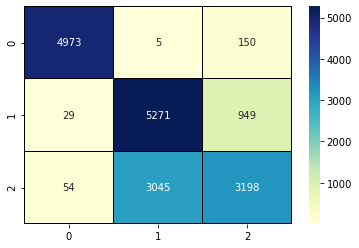

In [33]:
confMatrix = confusion_matrix(y_val, gnb_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, gnb_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,gnb_pred)
print("Accuracy:",result2)

### XGBOOST 

In [34]:
import xgboost
xgb=xgboost.XGBClassifier(n_estimators=150,eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xgb_p=xgb.predict(X_val)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5128
           2       1.00      1.00      1.00      6249
           3       1.00      1.00      1.00      6297

    accuracy                           1.00     17674
   macro avg       1.00      1.00      1.00     17674
weighted avg       1.00      1.00      1.00     17674

Accuracy: 0.9998868394251442


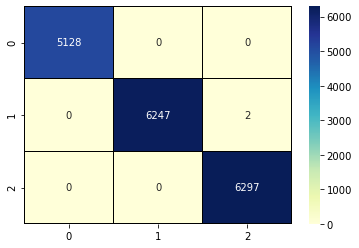

In [35]:
confMatrix = confusion_matrix(y_val, xgb_p)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, xgb_p,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,xgb_p)
print("Accuracy:",result2)

<B> As we can see almost all of the models as 0.99 score, but it is only on the train set, so for now it's ok.  
    If it will happen on the test set it will be problam.

<B> After trying some models i want to see the models after dimensionality reduction. 

## PCA

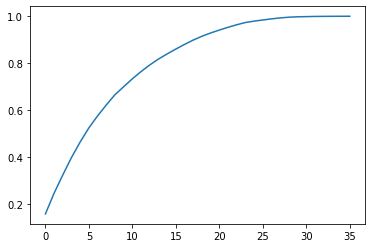

In [36]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(X_train)
sum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(sum)

<B> Lets try with 0.95 components.

In [37]:
pca=PCA(n_components=0.95)
#Fitting the data to the pca.
X_trainreduce=pca.fit_transform(X_train)
X_validreduce=pca.transform(X_val)

In [38]:
pca.n_components_

22

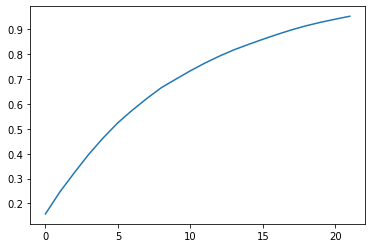

In [39]:
sum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(sum)

In [40]:
#Convert the data to data frame.
X_train_pca=pd.DataFrame(X_trainreduce)
X_valid_pca=pd.DataFrame(X_validreduce)

In [41]:
X_train_pca.shape

(70695, 22)

In [42]:
X_valid_pca.shape

(17674, 22)

### KNN after PCA

In [43]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 30))
acc = []
for k in k_range:
    knn_pca = KNeighborsClassifier(n_neighbors=k)
    knn_pca.fit(X_train_pca, y_train)
    neigh_pred_PCA = knn_pca.predict(X_valid_pca)
    acc.append(metrics.accuracy_score(y_val, neigh_pred_PCA))
acc

[0.9991512956885821,
 0.9989249745388706,
 0.9990381351137264,
 0.9983025913771642,
 0.9983591716645921,
 0.9977933687903134,
 0.9977367885028856,
 0.997170985628607,
 0.9970012447663235,
 0.9962091207423334,
 0.9960959601674777,
 0.9951906755686319,
 0.9946814529817811,
 0.9933801063709403,
 0.9925879823469503,
 0.9914563765983931,
 0.9910603145863981,
 0.9897589679755573,
 0.9897589679755573,
 0.988231300215005,
 0.9880615593527216,
 0.9871562747538758,
 0.98625099015503,
 0.9850062238316171,
 0.9846667421070499,
 0.9837048772207763,
 0.9834785560710648,
 0.982233789747652,
 0.9823469503225076]

### Logistic Regression after PCA

In [44]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train_pca,y_train)
clf_pred_pca=clf.predict(X_valid_pca)

Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.94      0.92      5128
           2       0.80      0.77      0.78      6249
           3       0.76      0.77      0.77      6297

    accuracy                           0.82     17674
   macro avg       0.82      0.83      0.83     17674
weighted avg       0.82      0.82      0.82     17674

Accuracy: 0.8189996605182754


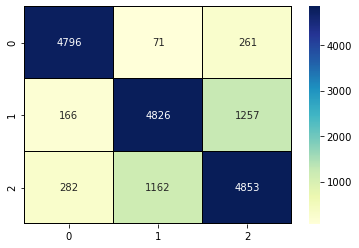

In [45]:
confMatrix = confusion_matrix(y_val, clf_pred_pca)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, clf_pred_pca,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,clf_pred_pca)
print("Accuracy:",result2)

### XGBOOST after PCA

In [46]:
import xgboost
xgb=xgboost.XGBClassifier(n_estimators=150,eval_metric='mlogloss')
xgb.fit(X_train_pca,y_train)
xgb_pca=xgb.predict(X_valid_pca)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5128
           2       1.00      0.99      1.00      6249
           3       0.99      1.00      0.99      6297

    accuracy                           1.00     17674
   macro avg       1.00      1.00      1.00     17674
weighted avg       1.00      1.00      1.00     17674

Accuracy: 0.9962091207423334


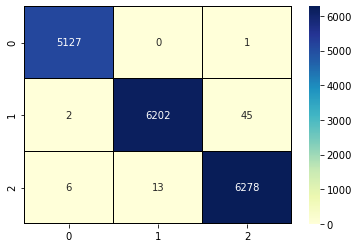

In [47]:
confMatrix = confusion_matrix(y_val, xgb_pca)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, xgb_pca,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,xgb_pca)
print("Accuracy:",result2)

###  Random Forest Classifier after PCA

In [48]:
rf_pca = RandomForestClassifier(random_state=10)
rf_pca.fit(X_train_pca, y_train)
rf_pred=rf_pca.predict(X_valid_pca)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5128
           2       1.00      0.99      0.99      6249
           3       0.99      1.00      0.99      6297

    accuracy                           1.00     17674
   macro avg       1.00      1.00      1.00     17674
weighted avg       1.00      1.00      1.00     17674

Accuracy: 0.995530157293199


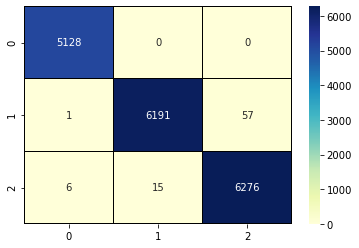

In [49]:
confMatrix = confusion_matrix(y_val, rf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, rf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,rf_pred)
print("Accuracy:",result2)

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test_test)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7364
           2       0.95      0.69      0.80      8806
           3       0.76      0.96      0.85      9063

    accuracy                           0.88     25233
   macro avg       0.90      0.88      0.88     25233
weighted avg       0.90      0.88      0.88     25233

Accuracy: 0.8782546665081441


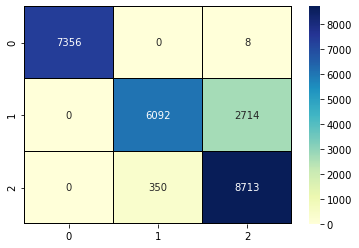

In [51]:
confMatrix = confusion_matrix(y_test_test, rf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test_test, rf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test_test,rf_pred)
print("Accuracy:",result2)

### Soft Voting Classifier 

In [52]:
from sklearn.ensemble import VotingClassifier
classifiers = [('Logistic Regression', clf),
               ('KNN', knn_pca),
               ('Xgboost', xgb),             
               ('Random Forest', rf_pca)]
for c_name, c in classifiers:
    c.fit(X_train_pca, y_train)
    preds = c.predict(X_valid_pca)
    print(f'{c_name} accuracy: {accuracy_score(y_val, preds)*100}')

Logistic Regression accuracy: 81.89996605182755
KNN accuracy: 98.23469503225077
Xgboost accuracy: 99.62091207423333
Random Forest accuracy: 99.55301572931991


In [53]:
VC_soft = VotingClassifier(estimators=classifiers, voting='soft')
VC_soft.fit(X_train_pca, y_train)
preds = VC_soft.predict(X_valid_pca)

In [54]:
soft_vc_pca = accuracy_score(y_val, preds)*100
print(f'Soft Voting Classifier score: {soft_vc_pca}')

Soft Voting Classifier score: 99.47946135566369


### Hard Voting Classifier

In [55]:
VC_hard = VotingClassifier(estimators=classifiers, voting='hard')
VC_hard.fit(X_train_pca, y_train)
preds = VC_hard.predict(X_valid_pca)

In [56]:
hard_vc_pca = accuracy_score(y_val, preds)*100
print(f'Hard Voting Classifier score: {hard_vc_pca}')

Hard Voting Classifier score: 99.25314020595225


<B> Almost all of the models gave perfect accuracy score on the training set.

## Test Set modeling

<B> Almost all of the model gave me perfect score on the train set,  
    so i will try most of the models on the test set.

### KNN on Test set

In [57]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 30))
acc = []
for k in k_range:
    knn_t = KNeighborsClassifier(n_neighbors=k)
    knn_t.fit(X_train, y_train)
    neigh_t = knn_t.predict(X_test_test)
    acc.append(metrics.accuracy_score(y_test_test, neigh_t))
acc

[0.8566559663932153,
 0.8549914794118812,
 0.8569730115325169,
 0.8573693179566441,
 0.8595093726469306,
 0.858637498513851,
 0.8603019854951849,
 0.8595490032893434,
 0.8599056790710577,
 0.8603812467800103,
 0.8608568144889629,
 0.8611342289858519,
 0.8617286886220425,
 0.8612134902706773,
 0.8617286886220425,
 0.8615701660523917,
 0.86125312091309,
 0.8619664724765188,
 0.8627987159671858,
 0.8625213014702968,
 0.8614116434827409,
 0.8622835176158206,
 0.86125312091309,
 0.8613720128403282,
 0.8614512741251535,
 0.86125312091309,
 0.8616097966948044,
 0.8612134902706773,
 0.8608568144889629]

### Random Forest Classifier on Test set

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test_test)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7364
           2       0.95      0.69      0.80      8806
           3       0.76      0.96      0.85      9063

    accuracy                           0.88     25233
   macro avg       0.90      0.88      0.88     25233
weighted avg       0.90      0.88      0.88     25233

Accuracy: 0.8782546665081441


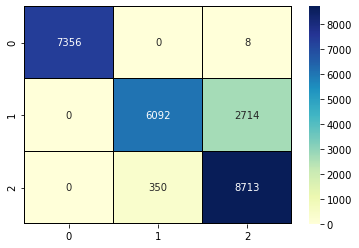

In [59]:
confMatrix = confusion_matrix(y_test_test, rf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test_test, rf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test_test,rf_pred)
print("Accuracy:",result2)

### XGBOOST on Test set

In [60]:
xgb_test=xgboost.XGBClassifier(n_estimators=150,eval_metric='mlogloss')
xgb_test.fit(X_train,y_train)
xgb_predtest=xgb_test.predict(X_test_test)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7364
           2       0.93      0.73      0.82      8806
           3       0.79      0.95      0.86      9063

    accuracy                           0.89     25233
   macro avg       0.91      0.89      0.89     25233
weighted avg       0.90      0.89      0.89     25233

Accuracy: 0.8877660206871953


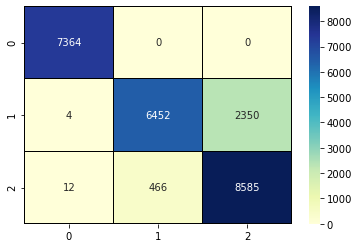

In [61]:
confMatrix = confusion_matrix(y_test_test, xgb_predtest)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test_test, xgb_predtest,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test_test,xgb_predtest)
print("Accuracy:",result2)

## Ensemble Learning on Test set

### Soft Voting

In [62]:
from sklearn.ensemble import VotingClassifier
classifiers = [('KNN', knn_t),
               ('Xgboost', xgb_test),             
               ('Random Forest', rf)]
for c_name, c in classifiers:
    c.fit(X_train, y_train)
    preds = c.predict(X_test_test)
    print(f'{c_name} accuracy: {accuracy_score(y_test_test, preds)*100}')

KNN accuracy: 86.0856814488963
Xgboost accuracy: 88.77660206871954
Random Forest accuracy: 87.8254666508144


In [63]:
VC_soft = VotingClassifier(estimators=classifiers, voting='soft')
VC_soft.fit(X_train, y_train)
preds = VC_soft.predict(X_test_test)

In [64]:
soft_vc_test = accuracy_score(y_test_test, preds)*100
print(f'Soft Voting Classifier score: {soft_vc_test}')

Soft Voting Classifier score: 89.10553640074505


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7364
           2       0.94      0.74      0.83      8806
           3       0.79      0.95      0.86      9063

    accuracy                           0.89     25233
   macro avg       0.91      0.90      0.90     25233
weighted avg       0.90      0.89      0.89     25233

Accuracy: 0.8910553640074506


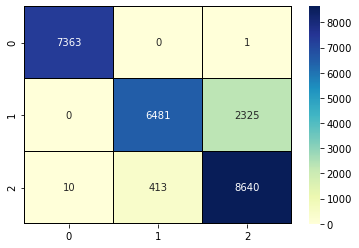

In [65]:
confMatrix = confusion_matrix(y_test_test, preds)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test_test, preds,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test_test,preds)
print("Accuracy:",result2)

### Hard Voting

In [66]:
VC_hard = VotingClassifier(estimators=classifiers, voting='hard')
VC_hard.fit(X_train, y_train)
preds = VC_hard.predict(X_test_test)

In [67]:
hard_vc_test = accuracy_score(y_test_test, preds)*100
print(f'Hard Voting Classifier score: {hard_vc_test}')

Hard Voting Classifier score: 88.77263900447826


## PCA on Test set

In [68]:
X_testreduce=pca.transform(X_test_test)

In [69]:
X_test_pca=pd.DataFrame(X_testreduce)

In [70]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 30))
acc = []
for k in k_range:
    knn_testpca = KNeighborsClassifier(n_neighbors=k)
    knn_testpca.fit(X_train_pca, y_train)
    neigh_test_PCA = knn_pca.predict(X_test_pca)
    acc.append(metrics.accuracy_score(y_test_test, neigh_test_PCA))
acc

[0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035,
 0.8591130662228035]

### Random Forest Classifier on test set with PCA 

In [71]:
rf_test_pca = RandomForestClassifier(random_state=10)
rf_test_pca.fit(X_train_pca, y_train)
rf_testpca=rf_test_pca.predict(X_test_pca)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99      7364
           2       0.94      0.67      0.78      8806
           3       0.75      0.96      0.84      9063

    accuracy                           0.87     25233
   macro avg       0.90      0.87      0.87     25233
weighted avg       0.89      0.87      0.87     25233

Accuracy: 0.868862204256331


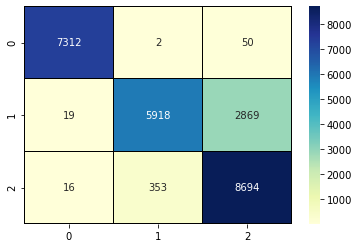

In [72]:
confMatrix = confusion_matrix(y_test_test, rf_testpca)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test_test, rf_testpca,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test_test,rf_testpca)
print("Accuracy:",result2)

### Logistic Regression on test set with PCA 

In [73]:
clf_pca = LogisticRegression(random_state=0)
clf_pca.fit(X_train_pca,y_train)
clf_test_pca=clf_pca.predict(X_test_pca)

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.93      0.85      7364
           2       0.91      0.58      0.71      8806
           3       0.71      0.85      0.77      9063

    accuracy                           0.78     25233
   macro avg       0.80      0.79      0.78     25233
weighted avg       0.80      0.78      0.77     25233

Accuracy: 0.7805255023183926


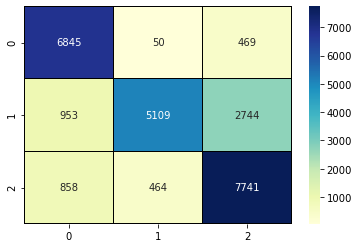

In [74]:
confMatrix = confusion_matrix(y_test_test, clf_test_pca)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test_test, clf_test_pca,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test_test,clf_test_pca)
print("Accuracy:",result2)

### XGBOOST on Test set with PCA 

In [75]:
xgb_test_pca=xgboost.XGBClassifier(n_estimators=150,eval_metric='mlogloss')
xgb_test_pca.fit(X_train_pca,y_train)
xgb_predtest=xgb_test_pca.predict(X_test_pca)

Classification Report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99      7364
           2       0.91      0.68      0.78      8806
           3       0.75      0.94      0.83      9063

    accuracy                           0.86     25233
   macro avg       0.89      0.87      0.87     25233
weighted avg       0.88      0.86      0.86     25233

Accuracy: 0.8649387706574724


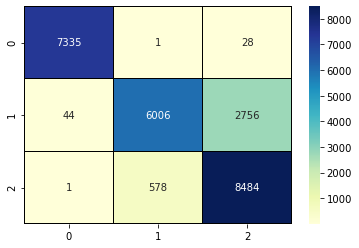

In [76]:
confMatrix = confusion_matrix(y_test_test, xgb_predtest)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test_test, xgb_predtest,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test_test,xgb_predtest)
print("Accuracy:",result2)

<B> Let's try Voting on the best models

In [77]:
from sklearn.ensemble import VotingClassifier
classifiers = [('KNN', knn_testpca),
               ('Xgboost', xgb_test_pca),             
               ('Random Forest', rf_test_pca)]
for c_name, c in classifiers:
    c.fit(X_train_pca, y_train)
    preds = c.predict(X_test_pca)
    print(f'{c_name} accuracy: {accuracy_score(y_test_test, preds)*100}')

KNN accuracy: 85.91130662228035
Xgboost accuracy: 86.49387706574724
Random Forest accuracy: 86.8862204256331


### Soft voting on test set with PCA

In [78]:
VC_soft = VotingClassifier(estimators=classifiers, voting='soft')
VC_soft.fit(X_train_pca, y_train)
preds = VC_soft.predict(X_test_pca)

In [79]:
soft_vc_test_pca = accuracy_score(y_test_test, preds)*100
print(f'Soft Voting Classifier score: {soft_vc_test_pca}')

Soft Voting Classifier score: 88.02758292711925


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7364
           2       0.92      0.72      0.81      8806
           3       0.77      0.94      0.85      9063

    accuracy                           0.88     25233
   macro avg       0.90      0.89      0.89     25233
weighted avg       0.89      0.88      0.88     25233

Accuracy: 0.8802758292711925


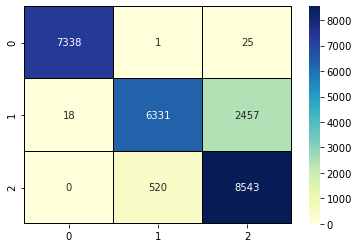

In [80]:
confMatrix = confusion_matrix(y_test_test, preds)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test_test, preds,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test_test,preds)
print("Accuracy:",result2)

### Hard voting on test set with PCA

In [81]:
VC_hard = VotingClassifier(estimators=classifiers, voting='hard')
VC_hard.fit(X_train_pca, y_train)
preds = VC_hard.predict(X_test_pca)

In [82]:
hard_vc_test_pca = accuracy_score(y_test_test, preds)*100
print(f'Hard Voting Classifier score: {hard_vc_test_pca}')

Hard Voting Classifier score: 87.94832164229382


<B> As we can see the test set is ok (as less then 0.99 score).  
    The best score without PCA was with soft voting classifier and the score was 0.89.  
    And with PCA the best score was also with the soft voting classifier and was 0.88.  
    As it look the best model for the hand data set is the soft voting classifier, it was consistent by giving the 
    best score with PCA and without it.  
    So for conclusion we got good score and also we got 0.88 score for the f-1 score! (with PCA).  
    
    